gg-napari-env

In [16]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
from tqdm import tqdm
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from scipy.ndimage import binary_dilation, generate_binary_structure
from skimage import exposure
import sys 
from concurrent.futures import ThreadPoolExecutor, as_completed
import xml.etree.ElementTree as ET
from plotting import * 
white_plotting()
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

2025-04-03 14:49:06,392 [INFO] Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Could not set the fontsize (invalid pixel size; error code 0x17)
2025-04-03 14:49:06,459 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2025-04-03 14:49:06,461 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-04-03 14:49:06,462 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

In [17]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, image, metadata, all_rois, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results, x=c1, y=c2, s=10, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[results['image'] == file].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"Normalized {c1_name} Intensity", fontsize=6) 
    ax.set_ylabel(f"Normalized {c2_name} Intensity", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='bold')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='bold')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))

        plt.tight_layout(pad=0)
        plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png",
                    format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()

In [18]:
def parse_marker_file_z_major(xml_file_path, num_channels):
    """
    Parses an ImageJ Cell Counter XML marker file where Z indices are flattened
    assuming Z-major ordering (Z slices vary fastest, channels slowest), and
    the flattened indices (MarkerZ) are 1-based.

    MarkerZ was calculated in ImageJ as:
        MarkerZ = (z - 1) * num_channels + (channel - 1) + 1
                = 1-based linear index assuming Z-major ordering.

    This function reverses that logic to recover the true Z slice and channel
    as 0-based indices:

        z = (MarkerZ - 1) // num_channels
        channel = (MarkerZ - 1) % num_channels

    Parameters:
    -----------
    xml_file_path : str
        Path to the XML file exported from the ImageJ Cell Counter plugin.

    num_channels : int
        The number of image channels (e.g., 4 if using DAPI, 488, 546, 647).

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the following columns:
            - 'name'    : The marker type name from the XML (e.g., "488C")
            - 'x'       : Marker X coordinate
            - 'y'       : Marker Y coordinate
            - 'z'       : Recovered Z slice index (0-based)
            - 'channel' : Recovered channel index (0-based)
            - 'image'   : Inferred image filename from XML name
            - 'cytoplasmic' : Derived label from marker name (e.g., "AF488")

    Notes:
    ------
    This has been validated with a test placing markers on:
        - z=1, c=1 → MarkerZ = 1
        - z=1, c=2 → MarkerZ = 2
        - z=1, c=3 → MarkerZ = 3
        - z=2, c=1 → MarkerZ = 4
        - z=2, c=2 → MarkerZ = 5
        - z=2, c=3 → MarkerZ = 6

    The function correctly recovers:
        - z = 0-based z index (e.g., MarkerZ = 4 → z=1)
        - channel = 0-based channel index (e.g., MarkerZ = 4 → channel=0)
    """
    import xml.etree.ElementTree as ET
    import pandas as pd

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    data = []
    for marker_type in root.findall(".//Marker_Type"):
        name = marker_type.findtext("Name")
        for marker in marker_type.findall("Marker"):
            x = int(marker.findtext("MarkerX"))
            y = int(marker.findtext("MarkerY"))
            z_raw = int(marker.findtext("MarkerZ"))

            # Adjust for 1-based MarkerZ
            z_index = z_raw - 1
            z = z_index // num_channels        # 0-based Z slice
            channel = z_index % num_channels   # 0-based channel index

            data.append({
                'name': name,
                'x': x,
                'y': y,
                'z': z,
                'channel': channel
            })

    df = pd.DataFrame(data)
    df['image'] = xml_file_path.split('CellCounter_')[1].replace('.xml', '.czi')
    df['cytoplasmic'] = df['name'].apply(lambda x: "AF" + x.split("C")[0])
    return df


In [19]:
def load_cytoplasmic_cell_counts(input, channels, channel_names, normalization=0.001): 
    results_dir = f'../results/{input}'
    results_files = os.listdir(results_dir)
    results_files = [f for f in results_files if f.endswith('.csv')]

    # Load all results 
    results = pd.DataFrame() 
    for f in results_files:
        results_path = os.path.join(results_dir, f)
        results_individual = pd.read_csv(results_path)
        results_individual.columns = results_individual.columns.str.split('-T').str[0]
        results = pd.concat([results, results_individual], axis=0) 
    results = results.reset_index(drop=True)

    # Normalize intensities for each sample using robust quantile-based normalization 
    # This approach "clips" extreme values without discarding them entirely
    for sample in results['image'].unique():
        results_sample = results[results['image'] == sample]
        for channel in channels: 
            #lower = results_sample[channel].quantile(normalization)
            #upper = results_sample[channel].quantile(1-normalization)
            #results_sample[channel] = (results_sample[channel] - lower) / (upper - lower)
            results_sample[channel] = (results_sample[channel] - results_sample[channel].min()) / (results_sample[channel].max() - results_sample[channel].min())
        results.loc[results['image'] == sample] = results_sample

    cell_counts_dir = f'../cytoplasmic-markers/{input}'
    cell_counts_files = os.listdir(cell_counts_dir)
    cellcounts = [] 
    for f in cell_counts_files:
        xml_path = os.path.join(cell_counts_dir, f)
        df = parse_marker_file_z_major(xml_path, num_channels=(len(channels)+1))
        cellcounts.append(df)
    cellcounts = pd.concat(cellcounts, axis=0)
    
    results['cytoplasmic'] = None

    # Iterate through each image
    for image in cellcounts['image'].unique(): 
        # Load ROIs 
        all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
        all_rois = np.load(all_rois_path)
        
        # Get subset of cellcounts for this image
        cellcounts_image = cellcounts[cellcounts['image'] == image]

        # Iterate through each cell 
        for i, cell in cellcounts_image.iterrows():
            rois_z = all_rois[cell['z'], :, :]

            # Get the region label at the cell's coordinates
            region_label = rois_z[cell['y'], cell['x']]  # Note: numpy uses row (y), col (x)

            if region_label > 0: 
                # Get the results row for this cell 
                results_row = results.loc[(results['image'] == cell['image']) & 
                                        (results['z'] == cell['z']) & 
                                        (results['z_id'] == region_label)]
                if len(results_row) == 1: 
                    results.loc[results_row.index[0], 'cytoplasmic'] = cell['cytoplasmic']

    # Get only cytoplasmic cells 
    results_cytoplasmic = results[results['cytoplasmic'].notnull()]

    # Melt the results, grouping by image and channel 
    results_cytoplasmic_melted = results_cytoplasmic.melt(id_vars=['image', 'cytoplasmic'],
                         value_vars=channels,
                         var_name='channel',
                         value_name='intensity').groupby(['image', 'cytoplasmic', 'channel']).mean().reset_index()

    
    # Add the number of cells to the dataframe
    results_cytoplasmic_melted['num_cells'] = results_cytoplasmic_melted.apply(
                                            lambda x: results[(results['image'] == x['image']) & 
                                                            (results['cytoplasmic'] == x['cytoplasmic'])].shape[0], axis=1)

    # Add channel names to the dataframe
    results_cytoplasmic_melted['channel_name'] = results_cytoplasmic_melted['channel'].map(dict(zip(channels, channel_names)))
    results_cytoplasmic_melted['cytoplasmic_name'] = results_cytoplasmic_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
    # Add " Cytoplasmic" to the cytoplasmic name
    results_cytoplasmic_melted['cytoplasmic_name'] = results_cytoplasmic_melted['cytoplasmic_name'] + " cytoplasmic"

    # Get cell counts 
    cytoplasmic_results_counts = results_cytoplasmic_melted.groupby(['image', 'cytoplasmic_name'])['num_cells'].max().reset_index()

    return results, results_cytoplasmic_melted, cytoplasmic_results_counts

In [20]:
def plot_cell(image, cell, c1, c2, c1_name, c2_name, c1_color, c2_color, metadata, 
              pixel_bounds=100, bbox_expansion=5, dapi_max=255, c1_max=255, c2_max=255): 
    
    # Get channels
    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]
    
    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range
    
    # Retrieve image and z slice 
    x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
    y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
    cell_image = image[cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)

    # Create composite RGB image
    rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

    # -- DAPI (Grey): add to all channels
    dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
    dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
    rgb_image[..., 0] += dapi_adjusted  # Red
    rgb_image[..., 1] += dapi_adjusted  # Green
    rgb_image[..., 2] += dapi_adjusted  # Blue

    # C1 
    c1_index = [idx for idx, channel in channels if c1 in channel][0]
    c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
    if c1_color == "magenta": 
        rgb_image[..., 0] += c1_adjusted  
        rgb_image[..., 2] += c1_adjusted  
    elif c1_color == "cyan": 
        rgb_image[..., 1] += c1_adjusted
        rgb_image[..., 2] += c1_adjusted
    elif c1_color == "yellow": 
        rgb_image[..., 0] += c1_adjusted
        rgb_image[..., 1] += c1_adjusted

    # -- Cyan (c2): add to green and blue
    c2_index = [idx for idx, channel in channels if c2 in channel][0]
    c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
    if c2_color == "magenta": 
        rgb_image[..., 0] += c2_adjusted  
        rgb_image[..., 2] += c2_adjusted  
    elif c2_color == "cyan": 
        rgb_image[..., 1] += c2_adjusted
        rgb_image[..., 2] += c2_adjusted
    elif c2_color == "yellow": 
        rgb_image[..., 0] += c2_adjusted
        rgb_image[..., 1] += c2_adjusted

    # Normalize composite image to [0,1]
    rgb_image = np.clip(rgb_image/255, 0, 1)

    # Load ROIs and compute bbox (adjusted relative to the cell image)
    regions = regionprops(all_rois[cell['z'], :, :])
    region_labels = [region.label for region in regions]
    region = regions[region_labels.index(cell['z_id'])]
    bbox = region.bbox
    # Expand bbox by bbox_expansion pixels     
    bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
            bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
    # Adjust bbox to cell_image coordinates
    bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
            bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
    # For clarity, unpack bbox (top, left, bottom, right)
    y1, x1, y2, x2 = bbox

    # Create figure with gridspec: main image in left column (spanning all rows) 
    # and three zoom panels in the right column (each taking 1/3 height)
    # Adjust fig size and width ratios as needed.
    fig_width = 1   # total width (main image + zoom panels)
    fig_height = 0.75  # height of the main image (zoom panels share this height)
    f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
    gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
    ax_main = f.add_subplot(gs[:, 0])
    ax_zoom_gray = f.add_subplot(gs[0, 1])
    ax_zoom_magenta = f.add_subplot(gs[1, 1])
    ax_zoom_cyan = f.add_subplot(gs[2, 1])

    # Plot main composite image
    ax_main.imshow(rgb_image)
    ax_main.axis("off")

    # Add text legends on main image
    ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='bold')
    ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='bold')
    ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='bold')
    # Add scale bar on main image
    ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
    
    ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

    # ----- Create zoom panels -----
    # Zoom for Grey (DAPI)
    zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
    # Build RGB image: all channels get the DAPI intensity
    dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
    dapi_zoom[..., 0] = zoom_dapi
    dapi_zoom[..., 1] = zoom_dapi
    dapi_zoom[..., 2] = zoom_dapi
    dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
    ax_zoom_gray.imshow(dapi_zoom)
    ax_zoom_gray.axis("off")
    ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))

    # Zoom for Magenta (c1)
    zoom_c1 = c1_adjusted[y1:y2, x1:x2]
    # Build an RGB image: red and blue channels from c1
    zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
    if c1_color == "magenta": 
        zoom_c1_rgb[..., 0] += zoom_c1  
        zoom_c1_rgb[..., 2] += zoom_c1  
    elif c1_color == "cyan": 
        zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb[..., 2] += zoom_c1
    elif c1_color == "yellow": 
        zoom_c1_rgb[..., 0] += zoom_c1
        zoom_c1_rgb[..., 1] += zoom_c1
    zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
    ax_zoom_magenta.imshow(zoom_c1_rgb)
    ax_zoom_magenta.axis("off")
    ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))

    # Zoom for Cyan (c2)
    zoom_c2 = c2_adjusted[y1:y2, x1:x2]
    # Build an RGB image: green and blue channels from c2
    zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
    if c2_color == "magenta": 
        zoom_c2_rgb[..., 0] += zoom_c2  
        zoom_c2_rgb[..., 2] += zoom_c2  
    elif c2_color == "cyan": 
        zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb[..., 2] += zoom_c2
    elif c2_color == "yellow": 
        zoom_c2_rgb[..., 0] += zoom_c2
        zoom_c2_rgb[..., 1] += zoom_c2
    zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
    ax_zoom_cyan.imshow(zoom_c2_rgb)
    ax_zoom_cyan.axis("off")
    ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
    plt.show() 

## R2-b3-488 Q1-b1-546 Lnc6-b2-647

In [119]:
input = '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI'
channels = ['AF488', 'AF546', 'AF647']
channel_names = ['R2-3', 'Q1', 'PR']
all_results, cytoplasmic_results, cytoplasmic_results_counts = load_cytoplasmic_cell_counts(input, channels=channels, channel_names=channel_names, normalization=0.00001)
cytoplasmic_results.head()

,image,cytoplasmic,channel,intensity,num_cells,channel_name,cytoplasmic_name
0,20250328 2 Q1lnc sample 1.czi,AF488,AF488,0.642249,25,R2-3,R2-3 cytoplasmic
1,20250328 2 Q1lnc sample 1.czi,AF488,AF546,0.040153,25,Q1,R2-3 cytoplasmic
2,20250328 2 Q1lnc sample 1.czi,AF488,AF647,0.332697,25,PR,R2-3 cytoplasmic
3,20250328 2 Q1lnc sample 1.czi,AF546,AF488,0.300339,34,R2-3,Q1 cytoplasmic
4,20250328 2 Q1lnc sample 1.czi,AF546,AF546,0.561021,34,Q1,Q1 cytoplasmic


In [120]:
file_number = 2
results_files = os.listdir(f'../raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 4.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 4_rois.npy


In [121]:
results_image = all_results[all_results['image'] == image].reset_index(drop=True)
results_image

,z_id,image,z,count,area,centroid_x,centroid_y,AF546,AF488,AF647,cytoplasmic
0,1,20250328 2 Q1lnc sample 4.czi,27,0,7.622199,1232.568579,850.209476,0.017398,0.087577,0.022736,None
1,2,20250328 2 Q1lnc sample 4.czi,27,1,7.726743,1199.225092,869.398524,0.016685,0.082811,0.014291,None
2,3,20250328 2 Q1lnc sample 4.czi,27,2,6.063545,1143.921630,894.145768,0.021724,0.122991,0.013547,None
3,4,20250328 2 Q1lnc sample 4.czi,27,3,5.502810,1038.272884,1104.911917,0.014843,0.085807,0.010452,None
4,5,20250328 2 Q1lnc sample 4.czi,27,4,7.394103,1012.088689,1116.136247,0.008886,0.086527,0.012417,None
...,...,...,...,...,...,...,...,...,...,...,...
24711,26,20250328 2 Q1lnc sample 4.czi,96,24711,4.951578,1085.996161,986.902111,0.067789,0.268310,0.151906,None
24712,27,20250328 2 Q1lnc sample 4.czi,96,24712,8.373014,1052.861521,992.543700,0.139413,0.254792,0.091784,None
24713,28,20250328 2 Q1lnc sample 4.czi,96,24713,8.819702,1085.071121,1028.436422,0.088400,0.228234,0.110817,None
24714,29,20250328 2 Q1lnc sample 4.czi,96,24714,8.354006,1076.526735,1059.985210,0.087185,0.249621,0.095768,None


In [125]:
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
non_dapi_channels = [(i, metadata['name'][i].split('-T')[0]) for i in range(len(metadata['name'])) if i != dapi_index]
non_dapi_channels

[(0, 'AF546'), (1, 'AF488'), (3, 'AF647')]

In [126]:
def normalize_stack_by_dapi(image, dapi_channel=0, method='mean', eps=1e-8):
    """
    Normalize all non-DAPI channels in a z-stack using DAPI intensity as reference.

    Parameters:
    - image: np.ndarray, shape (Z, C, X, Y)
    - dapi_channel: int, index of the DAPI channel (in the C dimension)
    - method: str, 'mean', 'median', or 'max' for calculating DAPI intensity per z-slice
    - eps: small value to avoid division by zero

    Returns:
    - corrected: np.ndarray, shape (Z, C, X, Y)
    """
    
    z, c, x, y = image.shape
    corrected = np.zeros_like(image, dtype=np.uint8)

    # Extract DAPI channel across z
    dapi_stack = image[:, dapi_channel, :, :]

    # Compute per-slice intensity
    if method == 'mean':
        dapi_intensity = dapi_stack.mean(axis=(1, 2))
    elif method == 'median':
        dapi_intensity = np.median(dapi_stack, axis=(1, 2))
    elif method == 'max':
        dapi_intensity = dapi_stack.max(axis=(1, 2))
    else:
        raise ValueError("method must be 'mean', 'median', or 'max'")

    # Normalize: scale each slice by the ratio of max intensity to current slice intensity
    dapi_ref = np.max(dapi_intensity)
    correction_factors = dapi_ref / (dapi_intensity + eps)

    for z_idx in range(z):
        for ch in range(c):
            if ch == dapi_channel:
                # Leave DAPI channel unchanged
                corrected[z_idx, ch] = image[z_idx, ch]
            else:
                corrected[z_idx, ch] = (image[z_idx, ch] * correction_factors[z_idx])

    # Clip values to ensure they are within valid range for uint8
    corrected = np.clip(corrected, 0, 255).astype(np.uint8)
    
    return corrected

In [128]:
image_data = np.squeeze(image_data)

In [129]:
image_data = normalize_stack_by_dapi(image_data, dapi_channel=dapi_index, method='mean')

In [130]:
metadata

{'rgb': False,
 'channel_axis': 2,
 'translate': (0.0, 0.0, 0.0, 0.0),
 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125),
 'contrast_limits': None,
 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}

In [131]:
# Get the 'z' in results containing the most non-null values in "cytplasmic" 
z = results_image.groupby('z')['cytoplasmic'].apply(lambda x: x.notnull().sum()).idxmax()
num_cyto = results_image[results_image['z'] == z]['cytoplasmic'].notnull().sum()
print(f"Number of cytoplasmic cells in z={z}: {num_cyto}")
cyto_cells = results_image[(results_image['z'] == z) & (results_image['cytoplasmic'].notnull())]
cell = cyto_cells.iloc[1]
cell

Number of cytoplasmic cells in z=35: 8


z_id                                      25
image          20250328 2 Q1lnc sample 4.czi
z                                         35
count                                   1580
area                                6.234617
centroid_x                        1371.96189
centroid_y                        578.699695
AF546                               0.014632
AF488                               0.391731
AF647                               0.020109
cytoplasmic                            AF488
Name: 1580, dtype: object

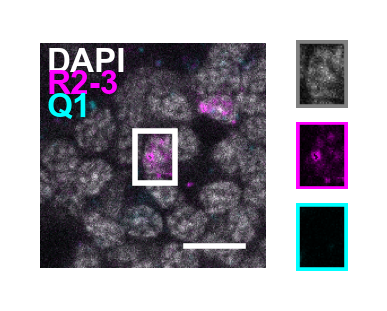

In [132]:
plot_cell(image_data, cell, c1='AF488', c2='AF546', c1_name='R2-3', c2_name='Q1', 
          c1_color='magenta', c2_color='cyan', metadata=metadata, pixel_bounds=100, 
          bbox_expansion=5, dapi_max=255, c1_max=255, c2_max=255)

In [ ]:
# Function to process each slice
def process_slice(z, all_rois, results, cell_borders, pixels_to_dilate, struct_elem):
    rois_slice = all_rois[z, :, :]
    cell_borders_slice = cell_borders[z, :, :]
    cells_slice = results[results['z'] == z]
    
    for i, cell in cells_slice.iterrows():
        # Get specific cell mask 
        cell_mask = rois_slice == cell['z_id']
        # Dilate region 
        dilated_mask = binary_dilation(cell_mask, structure=struct_elem, iterations=pixels_to_dilate)
        # Subtract the two regions using bitwise XOR
        cell_border = dilated_mask ^ cell_mask
        # create a temporary mask to store the cell border
        temp = cell_border 
        # Remove areas in cell_border where cell_borders is non-zero 
        cell_border[cell_borders_slice > 0] = 0
        # Remove areas in cell_border where the nuclei are non-zero 
        cell_border[rois_slice > 0] = 0
        # Remove areas in cell_borders where cell_border is non-zero
        cell_borders_slice[temp > 0] = 0
        # Save new areas to the cell_borders array 
        cell_borders_slice[cell_border] = cell['z_id']
    
    print(f"Finished processing z={z} with {len(cells_slice)} cells")
    # Return the updated slice to be stored back
    return z, cell_borders_slice

# Parallelize processing of Z slices
def parallelize_dilation(all_rois, results, cell_borders, pixels_to_dilate, struct_elem, n_threads):
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        # Create a list of futures to process each slice in parallel
        futures = [executor.submit(process_slice, z, all_rois, results, cell_borders, pixels_to_dilate, struct_elem) for z in range(all_rois.shape[0])]
        
        # Wait for all futures to complete and store the results
        for future in as_completed(futures):
            z, updated_cell_borders_slice = future.result()
            # After processing, store the updated slice back into cell_borders
            cell_borders[z, :, :] = updated_cell_borders_slice
    
    return cell_borders

In [134]:
pixels_to_dilate = 3 # pixels 
cell_borders = np.zeros_like(all_rois)
struct_elem = generate_binary_structure(2, 1)
# Call the parallelized function
cell_borders = parallelize_dilation(all_rois, results_image, cell_borders, pixels_to_dilate, struct_elem, n_threads=50)

Finished processing z=0 with 0 cells
Finished processing z=2 with 0 cells
Finished processing z=1 with 0 cells
Finished processing z=3 with 0 cells
Finished processing z=4 with 0 cells
Finished processing z=6 with 0 cells
Finished processing z=7 with 0 cells
Finished processing z=8 with 0 cells
Finished processing z=5 with 0 cells
Finished processing z=10 with 0 cells
Finished processing z=9 with 0 cells
Finished processing z=11 with 0 cells
Finished processing z=12 with 0 cells
Finished processing z=13 with 0 cells
Finished processing z=14 with 0 cells
Finished processing z=15 with 0 cells
Finished processing z=18 with 0 cells
Finished processing z=19 with 0 cells
Finished processing z=17 with 0 cells
Finished processing z=16 with 0 cells
Finished processing z=20 with 0 cells
Finished processing z=22 with 0 cells
Finished processing z=21 with 0 cells
Finished processing z=24 with 0 cells
Finished processing z=23 with 0 cells
Finished processing z=25 with 0 cells
Finished processing z=

In [37]:
def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

In [38]:
def random_colormap_transparent(mask):
    unique_labels = np.unique(mask)
    colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # RGBA image

    # Assign random colors
    np.random.seed(0)  # Ensure reproducibility
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3), dtype=np.uint8)
    colors = np.hstack((colors, np.full((len(unique_labels), 1), 255, dtype=np.uint8)))  # Add full opacity

    colors[0] = [0, 0, 0, 0]  # Make background transparent

    for i, label in enumerate(unique_labels):
        colored_mask[mask == label] = colors[i]

    return colored_mask

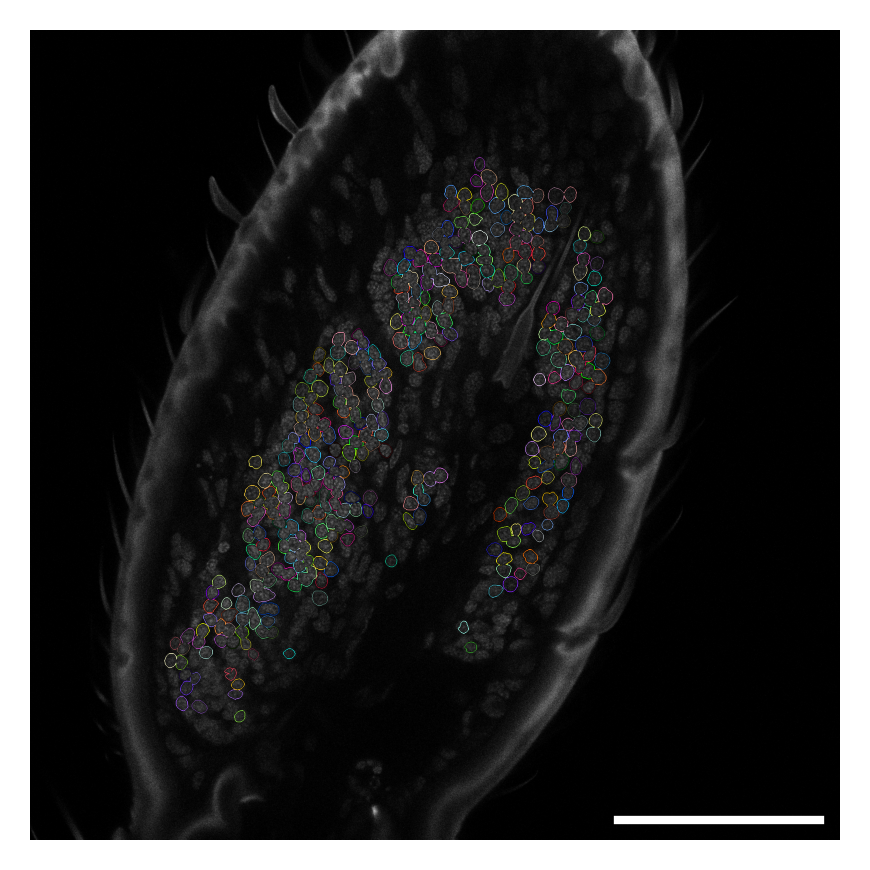

In [47]:
# choose 6 random zs 
num_z = 1
np.random.seed(0)
z_indices = np.random.choice(range(image_data.shape[0]), num_z)
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
gamma = 0.5  # <1 to brighten, >1 to darken
pixel_x = metadata['scale'][2]
nucleus_diameter = 3 / pixel_x

# Plot each channel for each z slice and the masks
for i, z in enumerate(z_indices):
    img = image_data[z, dapi_index, :, :]    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300) 
    ax.imshow(set_min_max(img, 0, 255), cmap='gray')
    rois = cell_borders[z, :, :]
    ax.imshow(random_colormap_transparent(rois)) 
    ax.axis('off')
    # Get scale for scale bar 
    x_scale = 50 / metadata['scale'][2] # 5 um in pixels 
    ax.plot([img.shape[1] - 50 - x_scale, img.shape[1] - 50], [img.shape[0] - 50, img.shape[0] - 50], color='white', lw=2)
    plt.tight_layout() 
    #plt.savefig(f"../figures/OOS-examples/{file.replace('.czi', f'_z{z}.pdf')}", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

## Measure in the border regions

In [111]:
# Function to process each slice
def quantify_border(z, image_data, results, cell_borders, channels):
    image_slice = image_data[z, :, :, :]
    cell_borders_slice = cell_borders[z, :, :]
    cells_slice = results[results['z'] == z]
    
    # Create list to store results for each cell
    cell_borders_results = [] 
    for i, cell in cells_slice.iterrows():
        cell_border_result = {} 
        cell_border_result['z'] = z
        cell_border_result['z_id'] = cell['z_id']
        cell_border_result['border_pxls'] = np.sum(cell_borders_slice == cell['z_id'])
        for channel, channel_name in channels:
            # Calculate mean intensity in the border area for each channel
            cell_border_result[channel_name + "-border"] = np.nanmean(image_slice[channel, cell_borders_slice == cell['z_id']])
        cell_borders_results.append(cell_border_result)
    
    # Convert the list of results to DataFrame
    cell_borders_results = pd.DataFrame(cell_borders_results)
    
    print(f"Finished processing z={z} with {len(cells_slice)} cells")
    
    return cell_borders_results

# Parallelize processing of Z slices
def parallelize_quantify_borders(image_data, results, cell_borders, channels, n_threads):
    # Create a list to collect results for each Z slice
    all_cell_border_results = []
    
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        # Create a list of futures to process each slice in parallel
        futures = [executor.submit(quantify_border, z, image_data, results, cell_borders, channels) for z in range(image_data.shape[0])]
        
        # Wait for all futures to complete and collect the results
        for future in as_completed(futures):
            cell_borders_results = future.result()
            all_cell_border_results.append(cell_borders_results)
    
    # Concatenate all results into a single DataFrame
    all_cell_border_results = pd.concat(all_cell_border_results, axis=0, ignore_index=True)
    
    # After processing all slices, merge the results with the original `results` DataFrame
    results = pd.merge(results, all_cell_border_results, on=['z', 'z_id'], how='left')
    
    return results

In [112]:
results_image = parallelize_quantify_borders(image_data, results_image, cell_borders, non_dapi_channels, n_threads=50)

Finished processing z=0 with 0 cells
Finished processing z=1 with 0 cells
Finished processing z=2 with 0 cells
Finished processing z=3 with 0 cells
Finished processing z=4 with 0 cells
Finished processing z=5 with 2 cells
Finished processing z=6 with 14 cells
Finished processing z=7 with 54 cells
Finished processing z=8 with 105 cells
Finished processing z=9 with 149 cells
Finished processing z=10 with 178 cells
Finished processing z=11 with 227 cells
Finished processing z=12 with 272 cells
Finished processing z=13 with 328 cells
Finished processing z=14 with 335 cells
Finished processing z=15 with 350 cells
Finished processing z=43 with 349 cells
Finished processing z=44 with 361 cells
Finished processing z=40 with 375 cells
Finished processing z=35 with 385 cells
Finished processing z=42 with 384 cells
Finished processing z=26 with 386 cells
Finished processing z=41 with 404 cells
Finished processing z=25 with 396 cells
Finished processing z=45 with 397 cells
Finished processing z=38

In [113]:
results_image

,z_id,image,z,count,area,centroid_x,centroid_y,AF546,AF488,AF647,border_pxls,AF546-border,AF488-border,AF647-border
0,1,20250328 2 Q1lnc sample 1.czi,5,0,6.177593,740.016923,1525.592308,6.176923,12.386154,6.330769,281,6.861210,13.291815,5.686833
1,2,20250328 2 Q1lnc sample 1.czi,5,1,4.457371,768.697228,1554.226013,10.906183,12.511727,9.298507,309,12.391586,14.896440,10.045307
2,1,20250328 2 Q1lnc sample 1.czi,6,2,5.959001,851.889952,1335.205742,4.204147,9.971292,3.979266,274,4.255474,10.883212,4.182482
3,2,20250328 2 Q1lnc sample 1.czi,6,3,5.113146,843.042751,1373.953532,7.568773,9.812268,5.434944,253,8.011858,10.047431,7.071146
4,3,20250328 2 Q1lnc sample 1.czi,6,4,7.327575,821.142672,1394.025940,9.710765,10.967575,8.757458,268,7.138060,11.690299,6.190299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25786,2,20250328 2 Q1lnc sample 1.czi,80,25786,6.633784,1057.196275,809.113181,12.464183,22.143266,7.485673,272,10.764706,25.294118,7.062500
25787,3,20250328 2 Q1lnc sample 1.czi,80,25787,6.215609,1096.162080,815.989297,13.249235,20.642202,7.740061,275,13.723636,23.574545,7.563636
25788,4,20250328 2 Q1lnc sample 1.czi,80,25788,5.711897,912.981697,1011.319468,11.299501,21.096506,9.737105,252,9.916667,23.468254,7.428571
25789,5,20250328 2 Q1lnc sample 1.czi,80,25789,8.211446,944.787037,1029.505787,10.047454,21.978009,8.013889,288,14.875000,23.340278,7.430556


In [114]:
# Melt results 
channels = ["AF488", "AF546", "AF647"]
border_melted = results_image.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'], 
                                value_vars=[c + "-border" for c in channels],
                                var_name='border_channel',
                                value_name='border_intensity')
nuclei_melted = results_image.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic'],
                                value_vars=channels,
                                var_name='nuclei_channel',
                                value_name='nuclei_intensity')
results_image_melted = pd.merge(border_melted, nuclei_melted, on=['image', 'z', 'z_id', 'cytoplasmic'], how='left')
results_image_melted

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['cytoplasmic']"

<Axes: xlabel='nuclei_channel', ylabel='nuclei_intensity'>

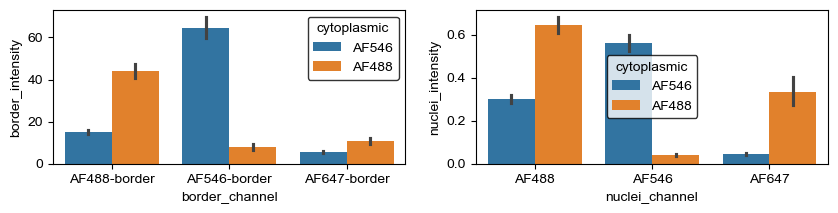

In [ ]:
# Plot bar plots of AF546-T1-border and AF647-T2-border split by cytoplasmic 
f, axs = plt.subplots(1, 2, figsize=(10, 2), dpi=100)
ax = axs[0]
sns.barplot(data=results_image_melted, x='border_channel', y='border_intensity', hue='cytoplasmic', ax=ax)
ax = axs[1]
sns.barplot(data=results_image_melted, x='nuclei_channel', y='nuclei_intensity', hue='cytoplasmic', ax=ax)

In [106]:
input

'20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI'